# Légi felvételek osztályozása

Az adatbázis (cvs fájl) tartalmazza a képi tartalomból kinyert spektrális értékeket.

Minden attribútum 0 és 255 közötti értéket vehet fel (0 a fekete és 255 a fehér). 

1 pixel a valóságban 80m x 80m-es területnek felel meg (ez az osztályozandó területek nagysága).

Utolsó oszlopban szerepelnek az osztályok:
1. red soil 		
2. cotton crop 		
3. grey soil
4. damp grey soil 	
5. soil with vegetation stubble 
6. mixture class (all types present) 
7. very damp grey soil 

(6-os osztályú most nincs az adathalmazban)

- Minden egyes sor (record) egy osztályozandó területhez tartozik, és ez nem csak az adott területet, hanem annak környezetét is leírja (3x3-as pixel környezetben, melynek a középső pixele az osztályozandó terület). 
- Az attribútumok (oszlopok): a képi jellemzők 4 különböző multi-spektrális értékkel (ebből 2 a látható tartománybeli elem és 2 pedig a nem láthatóban: infra-red). 
- Balról jobbra, majd lefele haladva: az első 4 attribútum a bal felső pixelhez, majd a következő négy a középső felső pixelhez, stb. tartozik, míg az utolsó 4 a jobb alsó pixelhez tartozik. 
- Így 4 spektrális érték és 9 pixel, összesen 4x9=36 attribútum jellemzi minden osztályozandó területet. (Ebből a 17., 18., 19. és 20. attribútum tartozik a 3x3 blokk középső pixeléhez.)

A tanuló állományban a sorok száma: 4435, a teszt halmazban pedig: 2000.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import arr2img
import numpy as np

ModuleNotFoundError: No module named 'utils'

# Adatok betöltése

In [2]:
# állítsuk elő az oszlopok fejléceit:
#   - a sorokat abc betűkkel jelöljük
#   - az oszlopokat 123 számokkal jelöljük
#   - minden pixelhez tartozik 4 csatorna, ezt "-" karakterrel elválasztva, számmal jelöljük
columns = [f"{row}{col}-{i}" for row in "abc" for col in "123" for i in range(4)] + ["class"]
df_train = pd.read_csv("data/sat.train.csv", sep=";", names=columns)
df_test = pd.read_csv("data/sat.testTrueValues.csv", sep=";", names=columns)

orig_X_train = df_train[columns[:-1]]
orig_y_train = df_train["class"]
orig_X_test = df_test[columns[:-1]]
orig_y_test = df_test["class"]

# Nézzük meg a tanító adathalmazt

In [3]:
orig_X_train.head()

,a1-0,a1-1,a1-2,a1-3,a2-0,a2-1,a2-2,a2-3,a3-0,a3-1,...,c1-2,c1-3,c2-0,c2-1,c2-2,c2-3,c3-0,c3-1,c3-2,c3-3
0,92,115,120,94,84,102,106,79,84,102,...,134,104,88,121,128,100,84,107,113,87
1,84,102,106,79,84,102,102,83,80,102,...,128,100,84,107,113,87,84,99,104,79
2,84,102,102,83,80,102,102,79,84,94,...,113,87,84,99,104,79,84,99,104,79
3,80,102,102,79,84,94,102,79,80,94,...,104,79,84,99,104,79,84,103,104,79
4,84,94,102,79,80,94,98,76,80,102,...,104,79,84,103,104,79,79,107,109,87


A tanítóhalmazon tudunk vizualizációt készíteni az `arr2img` függvény segítségével. 
- A függvény 1 vagy 2 dimenziós numpy tömböt vár. 
- Az egyes tanítópontokhoz megfelelő értékek az első dimenzió mentén helyezkedjenek el!
- Az (opcionális) második dimenzió mentén különböző csatornákat (C) adhatunk meg. 
- A visszaadott numpy tömb WxHxC méretű, kezelhetjük képként vizualizációkhoz.

*Megjegyzés: A függvény által visszaadott kép csak egy nem tökéletes közelítése az eredeti adathalmaznak! Mintákat viszont ezen is megfigyelhetünk!*

Példaként jelenítsük meg az adathalmazban az első három csatorna értékét minden rekordra a középső pixelre:

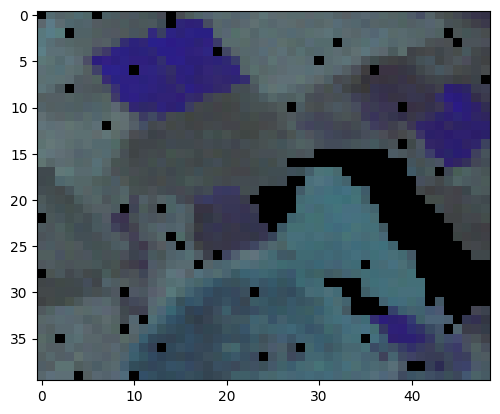

In [4]:
plt.imshow(arr2img(orig_X_train[["b2-0", "b2-1", "b2-2"]].values) / 255)

Láthazjuk, hogy nem teljes az adathalmaz, vannak benne hiányzó foltok (pixelek).

A következő cellában jelenítsük meg az egyes pixelekhez tartozó osztályokat:

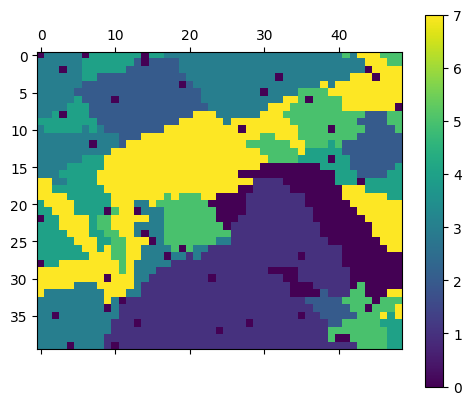

In [5]:
plt.matshow(arr2img(orig_y_train.values))
plt.colorbar()

Végül tekintsük meg mely pixelekhez tartoznak tanítópontok:

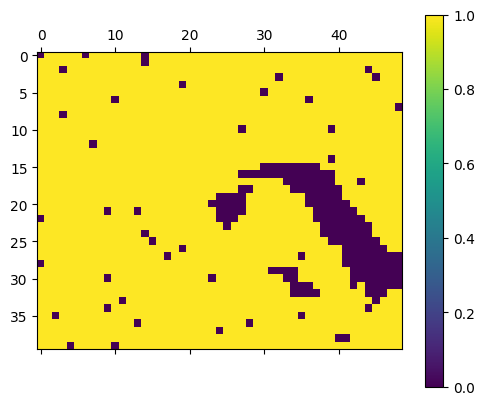

In [6]:
mask_train = arr2img(np.ones(orig_y_train.shape))
plt.matshow(mask_train)
plt.colorbar()

# Csak középpont koordináta alapján

Tanítson és értékeljen ki tetszőleges modellt kizárólag a 3x3 cellák középső pixelének értékei alapján!

In [21]:
# Középső pixelhez tartozó oszlopok
center_cols = [f"b2-{i}" for i in range(4)]

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_train = orig_X_train[center_cols].copy()
X_test = orig_X_test[center_cols].copy()

model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression())
])
model.fit(X_train, orig_y_train)
y_pred = model.predict(X_test)
print(classification_report(orig_y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       461
           2       0.92      0.91      0.91       224
           3       0.83      0.94      0.88       397
           4       0.54      0.25      0.34       211
           5       0.82      0.65      0.73       237
           7       0.72      0.86      0.78       470

    accuracy                           0.82      2000
   macro avg       0.79      0.77      0.77      2000
weighted avg       0.81      0.82      0.81      2000



In [23]:
CLASS_IDX=3
proba_center = arr2img(model.predict_proba(X_train)[:, CLASS_IDX])
pred_center = model.predict(X_train)

# 3x3 részlet alapján
- Használja a rendelkezésre álló teljes információt (összes oszlopot) modell tanításához. 
- Értékelje ki a modellt és hasonlítsa össze az eredményeket a kizárólag középső pixellel dolgozó modell eredményeivel.
- Mit tapasztal?

In [24]:
X_train = orig_X_train.copy()
X_test = orig_X_test.copy()

model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])
model.fit(X_train, orig_y_train)
y_pred = model.predict(X_test)
print(classification_report(orig_y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.98       461
           2       0.95      0.93      0.94       224
           3       0.86      0.93      0.89       397
           4       0.51      0.30      0.38       211
           5       0.84      0.76      0.80       237
           7       0.75      0.86      0.80       470

    accuracy                           0.84      2000
   macro avg       0.81      0.79      0.80      2000
weighted avg       0.83      0.84      0.83      2000



In [26]:
proba_surrounding = arr2img(model.predict_proba(X_train)[:, CLASS_IDX])
pred_surrounding = model.predict(X_train)

# Polynomial features
- Használja a `scikit-learn` csomag `PolynomialFeatures` modulját, hogy új attribútumokat hozzon létre!
- Tanítson új modellt az eredeti és új attribútumokon!
- Hasonlítsa össze az eredményeket az előző két modellel!
- Mit tapasztal?

In [27]:
from sklearn.preprocessing import PolynomialFeatures
X_train = orig_X_train.copy()
X_test = orig_X_test.copy()

model = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2500))
])
model.fit(X_train, orig_y_train)
y_pred = model.predict(X_test)

print(classification_report(orig_y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       461
           2       0.98      0.97      0.98       224
           3       0.89      0.92      0.90       397
           4       0.64      0.52      0.57       211
           5       0.90      0.86      0.88       237
           7       0.81      0.87      0.84       470

    accuracy                           0.88      2000
   macro avg       0.87      0.85      0.86      2000
weighted avg       0.88      0.88      0.88      2000



In [28]:
proba_poly = arr2img(model.predict_proba(X_train)[:, CLASS_IDX])
pred_poly = model.predict(X_train)

Hasonlítsuk össze a három modell (*center*, *surrounding*, *poly*) predikcióinak helyességét:

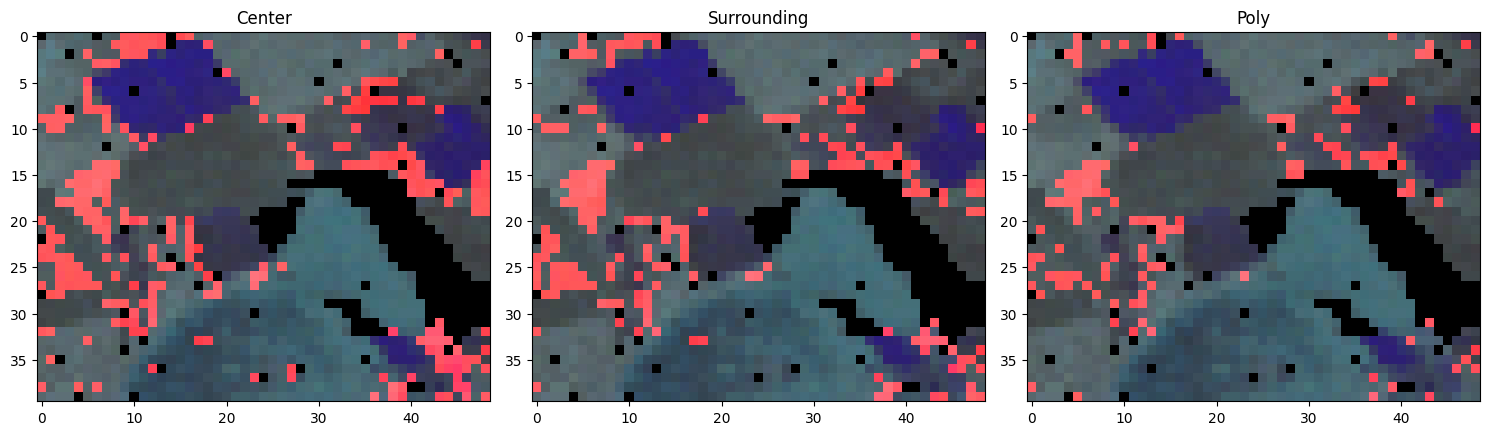

In [29]:
# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
map2_base = arr2img(orig_X_train[["b2-0", "b2-1", "b2-2"]].values) / 255
# Create the matrix plots using the same vmin and vmax for consistency
map1 = arr2img((pred_center != orig_y_train.values))
map2 = map2_base.copy()
map2[:, :, 0] = map2[:, :, 0] + map1.squeeze()
blended = np.clip(map2, a_min=0, a_max=1)
axs[0].imshow(blended)
axs[0].set_title("Center")


map1 = arr2img((pred_surrounding != orig_y_train.values))
map2 = map2_base.copy()
map2[:, :, 0] = map2[:, :, 0] + map1.squeeze()
blended = np.clip(map2, a_min=0, a_max=1)
axs[1].imshow(blended)
axs[1].set_title("Surrounding")

map1 = arr2img((pred_poly != orig_y_train.values))
map2 = map2_base.copy()
map2[:, :, 0] = map2[:, :, 0] + map1.squeeze()
blended = np.clip(map2, a_min=0, a_max=1)
axs[2].imshow(blended)
axs[2].set_title("Poly")

# Adjust layout to make room for the colorbar
fig.tight_layout()

# Show the plot
plt.show()


Vizsgáljuk meg a 3 modell kimeneti valószínűségeit egy tetszőleges osztályra:

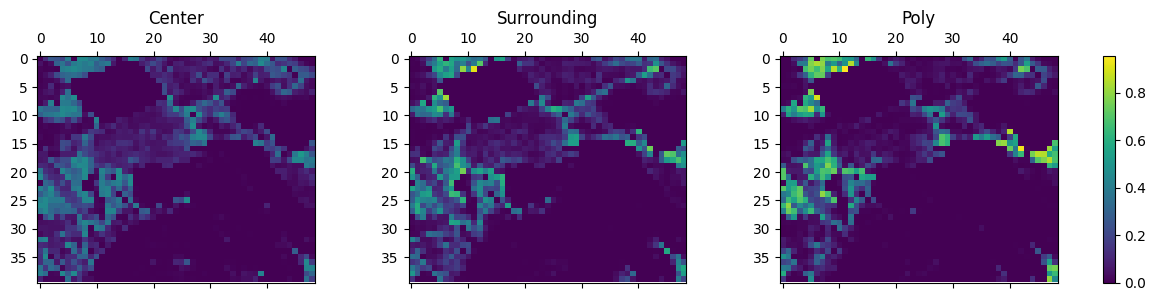

In [30]:
vmin = min(proba_center.min(), proba_surrounding.min(), proba_poly.min())
vmax = max(proba_center.max(), proba_surrounding.max(), proba_poly.max())

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Create the matrix plots using the same vmin and vmax for consistency
cmap = 'viridis'  # You can adjust the colormap if needed
im1 = axs[0].matshow(proba_center, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_title("Center")
im2 = axs[1].matshow(proba_surrounding, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].set_title("Surrounding")
im3 = axs[2].matshow(proba_poly, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].set_title("Poly")
"""cls_mask = arr2img(orig_y_train.values == CLASS_IDX)
mixture_mask =  arr2img(orig_y_train.values == 7)
combined = np.stack([cls_mask, mixture_mask, np.zeros_like(cls_mask)], axis=-1).squeeze()
im4 = axs[3].imshow(combined)
axs[3].set_title("Reference")
"""
# Adjust layout to make room for the colorbar
fig.tight_layout()

# Create a single colorbar for all plots
fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

# Show the plot
plt.show()


# Tanulság
- A közvetlen környezetből vett extra információval javítani tudunk a modell jóságán
- Egyszerű modell esetében az egyes attribútumok kombinálásával gyakran jobb eredményt érhetünk el